### Installing Libraries

In [1]:
! pip install pyreadr pandas matplotlib seaborn --quiet

### Importing Libraries

In [2]:
import pyreadr
import pandas as pd
import matplotlib.pyplot as plt

### Loading Data 

In [3]:
PATH = "/Users/amarnathreddykalluru/PycharmProjects/Resilience/data/portarthur_sd_df_2019.rdata"

result = pyreadr.read_r(PATH)
df = result['portarthur_sd_df_2019']
df["origin_census_block_group"] = df["origin_census_block_group"].astype(str)
df["destination_cbg"] = df["destination_cbg"].astype(str)
df["device_count"] = pd.to_numeric(df["device_count"], errors="coerce")
df["destination_device_count"] = pd.to_numeric(df["destination_device_count"], errors="coerce")
df["year"] = df["year"].astype(int)
df["uid"] = df["uid"].astype(int)
df["date"] = pd.to_datetime("2019-01-01") + pd.to_timedelta(df["uid"] - 1, unit="D")

county_map = {
    "48199": "Jefferson County",
    "48245": "Jeff Davis County",
    "48361": "Orange County"
}

### Disaster Scenarios

In [4]:
DISASTER_NAME = "Tropical Storm Imelda"
disaster_start = pd.to_datetime("2019-09-17")
disaster_end = pd.to_datetime("2019-09-27")

### MOBILITY PATTERNS OVERALL

In [5]:

def plot_overall_mobility(df, disaster_start, disaster_end, smoothing_window=7):
    
    own_df = df[df['origin_census_block_group'] == df['destination_cbg']]

    daily_own = own_df.groupby('date')['device_count'].sum().reset_index(name='own_visits')

    daily_own['own_visits_smoothed'] = daily_own['own_visits'].rolling(window=smoothing_window, min_periods=1).mean()

    plt.figure(figsize=(12, 6))
    plt.plot(daily_own['date'], daily_own['own_visits_smoothed'], color='blue', label='Own Mobility', linewidth=2)

    plt.axvspan(disaster_start, disaster_end, color='gray', alpha=0.3, label='Disaster Impact')
    
    plt.title("Own Mobility in Beaumont–Port Arthur Metro Area")
    plt.xlabel("Date")
    plt.ylabel("Number of Own Visits")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


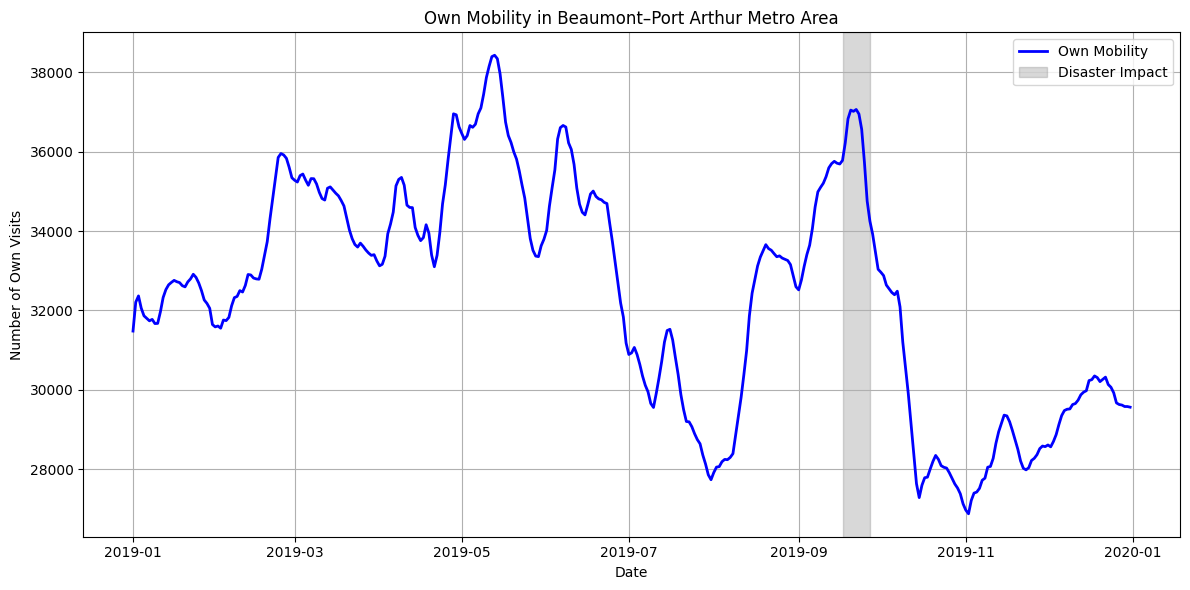

In [6]:
plot_overall_mobility(df, disaster_start, disaster_end)

### MOBILITY PATTERNS COUNTY LEVEL

In [7]:
def county_mobility_plot(df, county_fips, disaster_start, disaster_end, smoothing_window=7):

    county_name = county_map[county_fips]

    county_df = df[(df['from_cnt'] == county_fips) | (df['to_cnt'] == county_fips)].copy()

    county_df.loc[(county_df["from_cnt"] == county_fips) & (county_df['to_cnt'] == county_fips), 'movement_type'] = 'Own'
    county_df.loc[(county_df['from_cnt'] != county_fips) & (county_df['to_cnt'] == county_fips), 'movement_type'] = 'Inward'
    county_df.loc[(county_df['from_cnt'] == county_fips) & (county_df['to_cnt'] != county_fips), 'movement_type'] = 'Outward'

    daily_movements = county_df.groupby(['date', 'movement_type'])['destination_device_count'].sum().reset_index()

    pivot_df = daily_movements.pivot(index='date', columns='movement_type', values='destination_device_count').fillna(0)

    smoothed = pivot_df.rolling(window=smoothing_window, min_periods=1).mean()

    plt.figure(figsize=(12, 6))
    for movement in ['Inward', 'Outward', 'Own']:
        if movement in smoothed.columns:
            plt.plot(smoothed.index, smoothed[movement], label=movement)

    plt.axvspan(disaster_start, disaster_end, color='gray', alpha=0.4, label='Disaster Impact')

    plt.title(f"Time Series of Visits in {county_name} county")
    plt.xlabel("Date")
    plt.ylabel("Number of Visits")
    plt.legend(title='Source')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

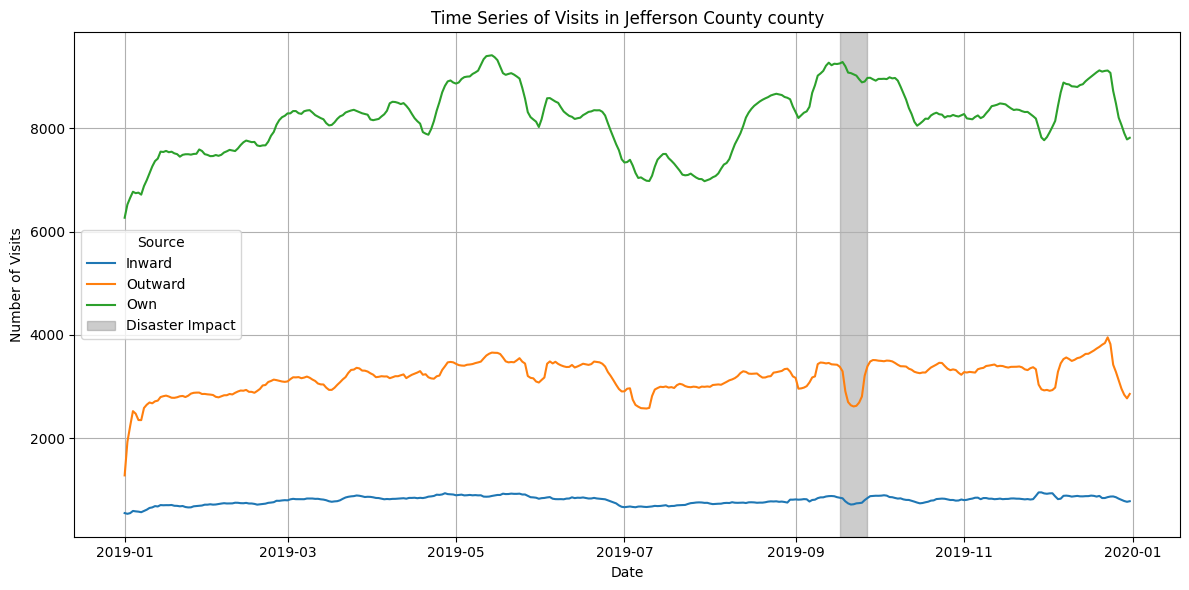

In [8]:
county_mobility_plot(df, "48199", disaster_start, disaster_end)

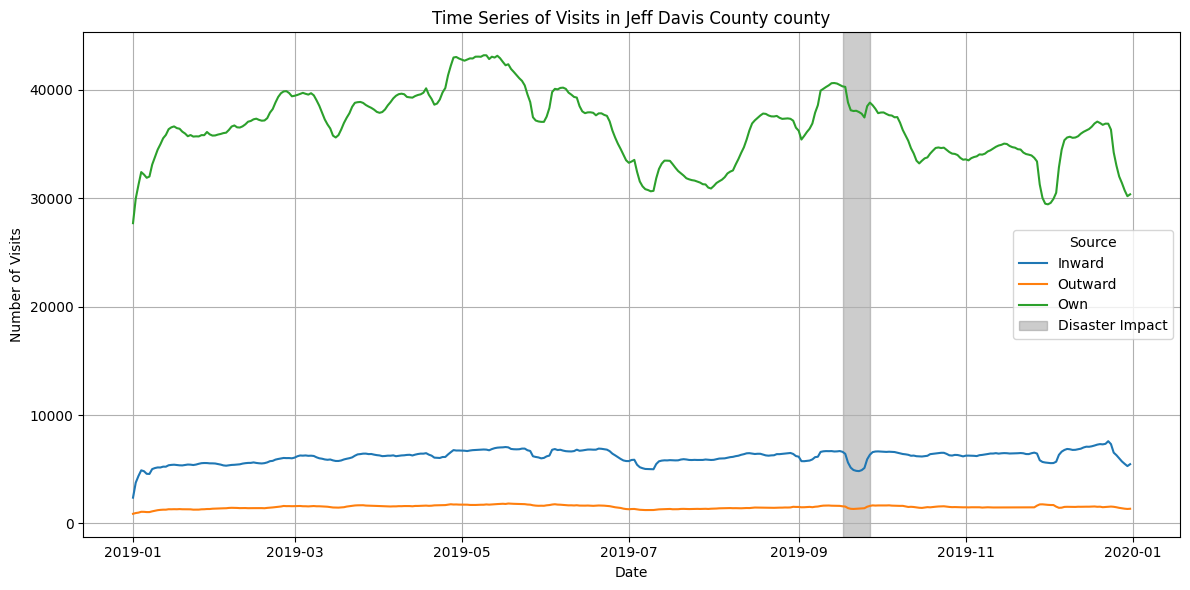

In [9]:
county_mobility_plot(df, "48245", disaster_start, disaster_end)

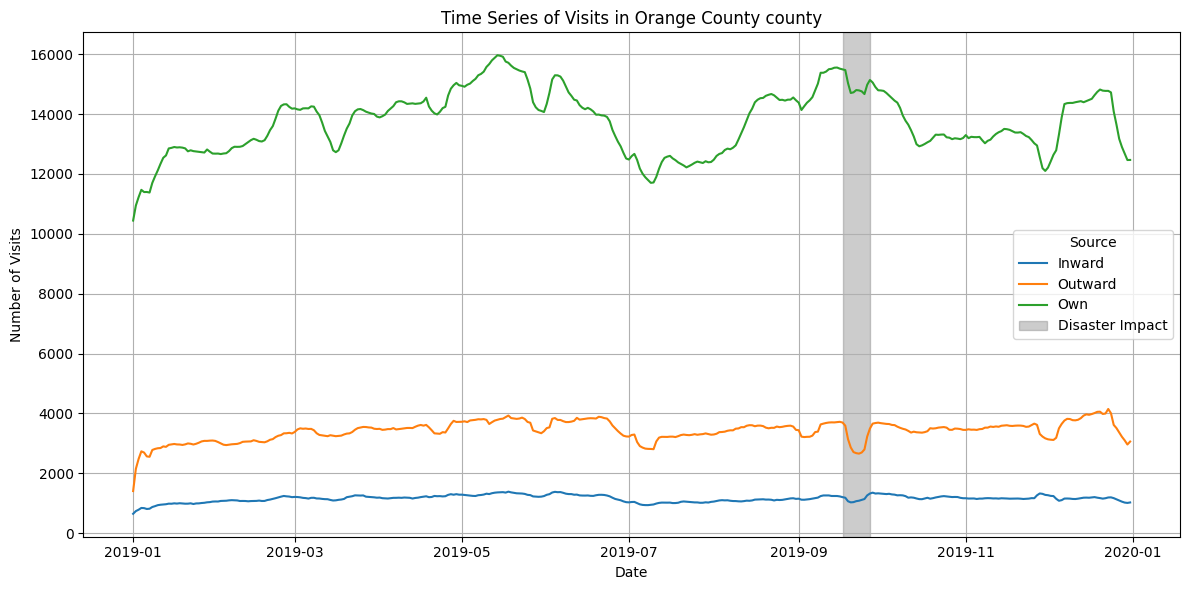

In [10]:
county_mobility_plot(df, "48361", disaster_start, disaster_end)

### MOBILITY PATTERNS CBG LEVEL

In [11]:
def cbg_mobility_plot(df, cbg_code, disaster_start, disaster_end, smoothing_window = 7):

    cbg_df = df[(df["origin_census_block_group"] == cbg_code) | (df['destination_cbg'] == cbg_code)].copy()

    cbg_df.loc[(cbg_df["origin_census_block_group"] == cbg_code) & (cbg_df["destination_cbg"] == cbg_code), 'movement_type'] = 'Own'
    cbg_df.loc[(cbg_df["origin_census_block_group"] != cbg_code) & (cbg_df["destination_cbg"] == cbg_code), 'movement_type'] = 'Inward'
    cbg_df.loc[(cbg_df["origin_census_block_group"] == cbg_code) & (cbg_df["destination_cbg"] != cbg_code), 'movement_type'] = 'Outward'

    daily_movements = cbg_df.groupby(['date', 'movement_type'])['destination_device_count'].sum().reset_index()
    pivot_df = daily_movements.pivot(index='date', columns='movement_type', values='destination_device_count').fillna(0)

    smoothed = pivot_df.rolling(window= smoothing_window, min_periods=1).mean()

    plt.figure(figsize=(12, 6))
    for movement in ['Inward', 'Outward', 'Own']:
        if movement in smoothed.columns:
            plt.plot(smoothed.index, smoothed[movement], label=movement)

    plt.axvspan(disaster_start, disaster_end, color='gray', alpha=0.4, label='Disaster Impact')

    plt.title(f"Time Series of Visits in CBG: {cbg_code}")
    plt.xlabel("Date")
    plt.ylabel("Number of Visits")
    plt.legend(title='Movement Type')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

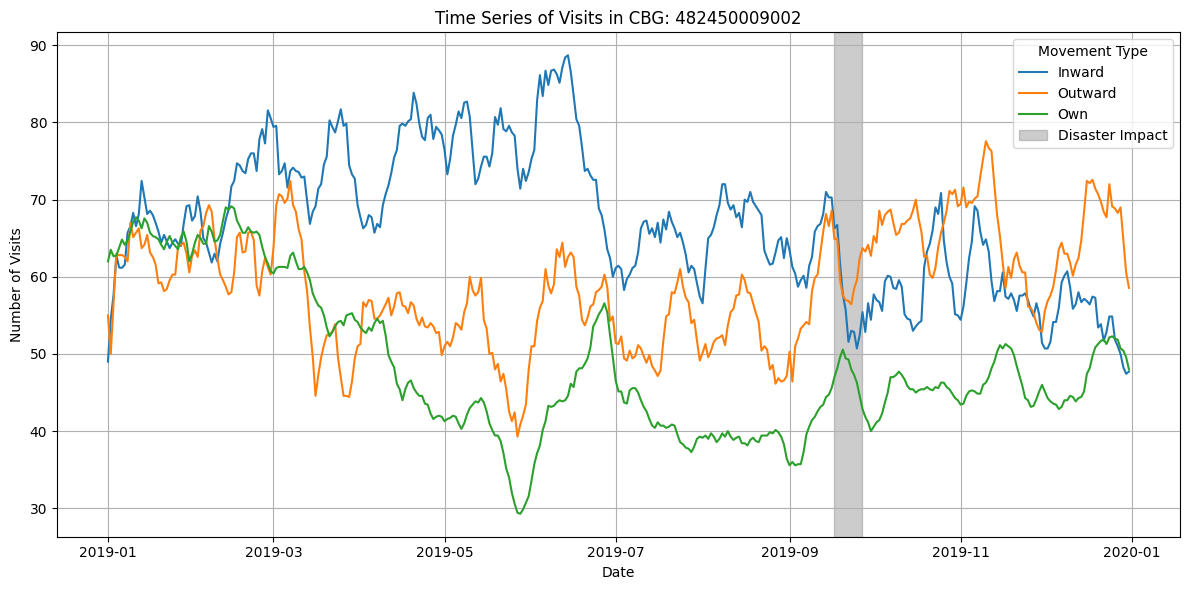

In [12]:
cbg_mobility_plot(df, "482450009002", disaster_start, disaster_end)

In [13]:
def plot_overall_mobility_at_cbg_level(df, disaster_start, disaster_end, smoothing_window=7):

    df = df.copy()
    
    df['movement_type'] = df.apply(
        lambda row: 'Own' if row['origin_census_block_group'] == row['destination_cbg'] else 'Cross', axis=1
    )

    daily_movements = df.groupby(['date', 'movement_type'])['destination_device_count'].sum().reset_index()

    pivot_df = daily_movements.pivot(index='date', columns='movement_type', values='destination_device_count').fillna(0)

    pivot_df['Own_smooth'] = pivot_df['Own'].rolling(window=smoothing_window, min_periods=1, center=True).mean()
    pivot_df['Cross_smooth'] = pivot_df['Cross'].rolling(window=smoothing_window, min_periods=1, center=True).mean()

    plt.figure(figsize=(12, 6))
    plt.plot(pivot_df.index, pivot_df['Own_smooth'], label='Own Movement (within CBG)', color='blue')
    plt.plot(pivot_df.index, pivot_df['Cross_smooth'], label='Cross-CBG Movement', color='orange')

    plt.axvspan(disaster_start, disaster_end, color='gray', alpha=0.3, label='Disaster Period')

    plt.title("Overall Mobility Across All CBGs")
    plt.xlabel("Date")
    plt.ylabel("Number of Visits")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

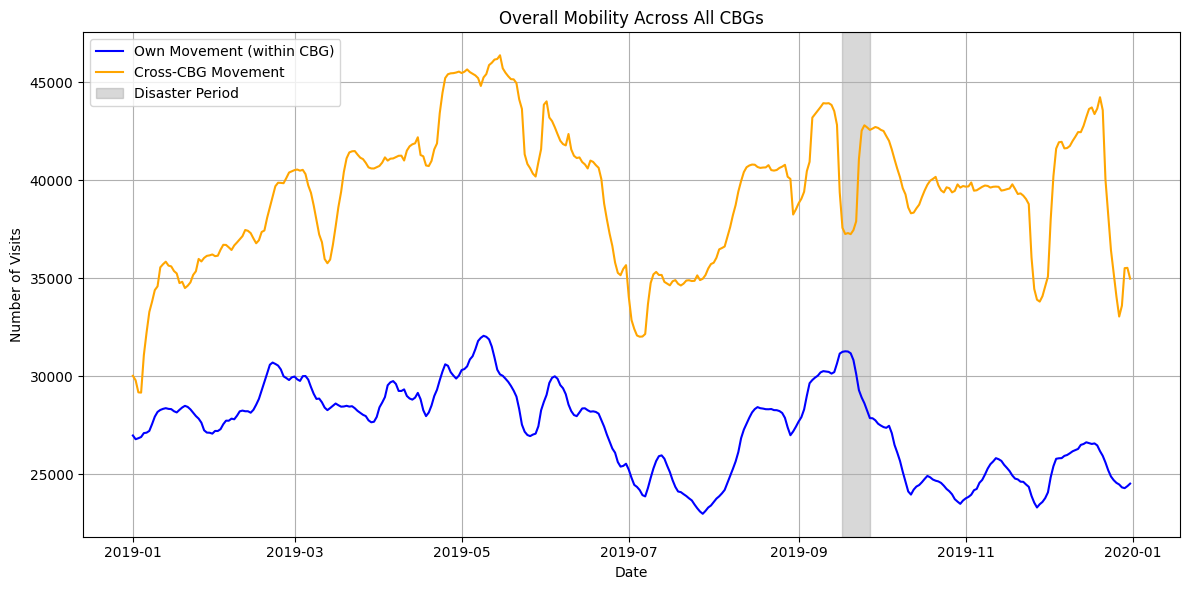

In [14]:
plot_overall_mobility_at_cbg_level(df,disaster_start,disaster_end)